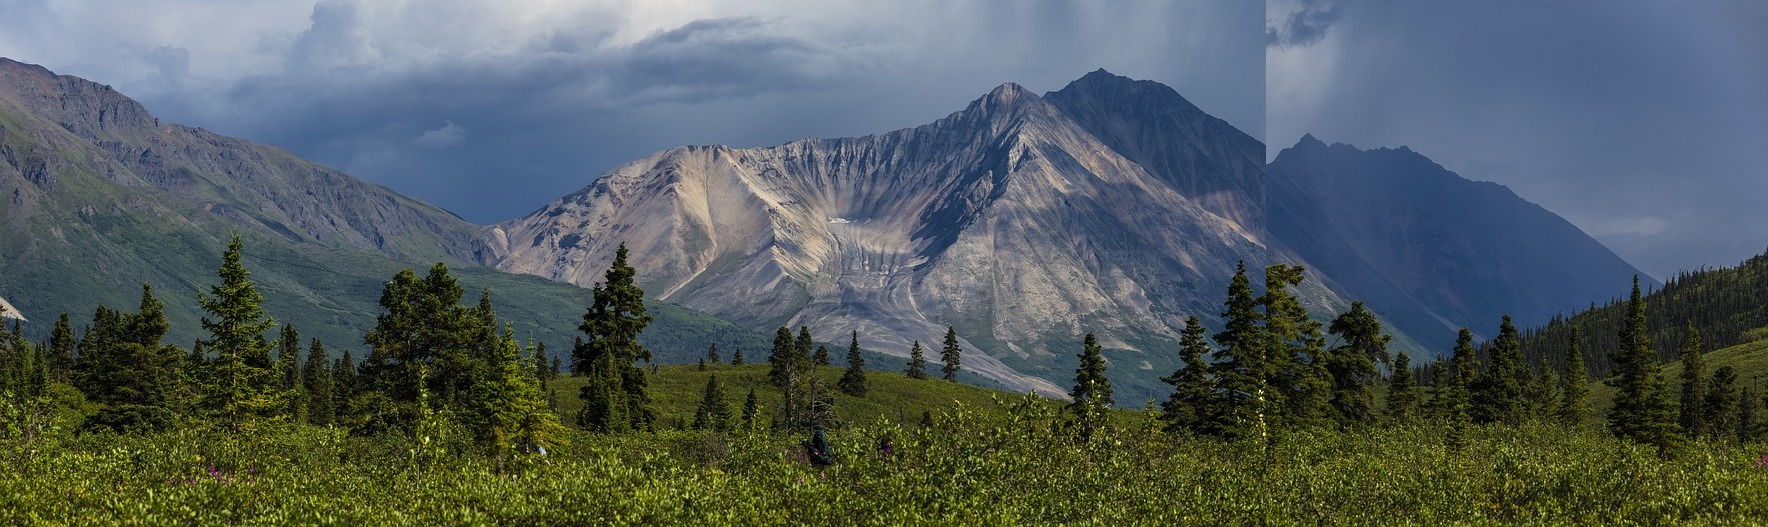

True

In [36]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

class Panaroma_Creation():
  def Panaroma_Stiching(self,images):
      #Detect Keypoints and descriptors in each image
      s=cv2.SIFT_create()
      key=[]
      des=[]
      for img in images:
        if img is None:
          print("Error Image Not Loaded")
          return None

        if img.dtype!=np.uint8:
          print("Error Image has Incorrect Depth . Expected CV_8U")
          return None

        k,d=s.detectAndCompute(img,None)
        key.append(k)
        des.append(d.astype(np.float32))

      #Match Descriptors between images using FLANN
      #FLANN-Fast Library for Approximate Nearest Neighbours
      #index=dict(algorithm=6,table_number=6,key_size=12,multi_probe_level=2)
      #search=dict(checks=50)
      #f=cv2.FlannBasedMatcher(index,search)
      #matches=f.knnMatch(des[0],des[1],k=2)

      #Match Descriptors between images using brute force matcher
      bf=cv2.BFMatcher(cv2.NORM_L2,crossCheck=False)
      matches=bf.knnMatch(des[0],des[1],k=2)

      #Apply ratio test to filter good matches
      good_match=[]
      for i,j in matches:
        if i.distance<0.7*j.distance:
          good_match.append(i)

      #Ensure we Have Atleast 4 corresponding set points
      if len(good_match)<4:
        print("Insuficient matches to complete homography")
        return None

      #Estimate Homography Matrix Between Two Images
      p1=np.array([key[0][m.queryIdx].pt for m in good_match]).reshape(-1,2)
      p2=np.array([key[1][m.trainIdx].pt for m in good_match]).reshape(-1,2)
      h,mask=cv2.findHomography(p1,p2,cv2.RANSAC,ransacReprojThreshold=3)

      #Warp second image to first image
      warped=cv2.warpPerspective(images[1],h,(images[0].shape[1],images[0].shape[0]))

      #Stich 2 images together
      stiched=np.concatenate((images[0],warped),axis=1)

      return stiched

  def Image_Cropping(self,image):
    #Convert Image to grey Pixels
    gray_img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    #Find right boundary of non black region
    rb=gray_img.shape[1]-1
    for col in range(gray_img.shape[1]-1,-1,-1):
      if np.any(gray_img[:,col]!=0):
        rb=col
        break

    cropped_image=image[:,:rb+1]
    return cropped_image

p=Panaroma_Creation()
i1=cv2.imread("./img1.jpg")
i2=cv2.imread("./img2.jpg")
result=p.Panaroma_Stiching([i1,i2])
final=p.Image_Cropping(result)
cv2_imshow(final)
cv2.imwrite("./result.jpg",final)